<a href="https://colab.research.google.com/github/rajdeepbanerjee-git/JNCLectures_Intro_to_ML/blob/main/Week9/Week9_Ridge_n_Lasso_Regression_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Ridge Regression

In [9]:
import numpy as np

def ridge(x, y, lam=0):
    """
    Computes the Ridge Regression solution with built-in data scaling.

    This function first standardizes the input data (centers and scales each feature
    and centers the response), then computes the Ridge Regression coefficients
    using the closed-form solution:

        beta = (X^T X + lam * I)^{-1} X^T y

    Finally, it adjusts the computed coefficients to revert the effect of scaling,
    and computes the intercept term.

    Parameters
    ----------
    x : np.ndarray
        The design matrix of shape (n, p). Each column represents a feature.
    y : np.ndarray
        The response vector of length n.
    lam : float, optional
        Regularization parameter (lambda). Default is 0 (ordinary least squares).

    Returns
    -------
    result : dict
        A dictionary with keys:
          - 'beta_0': The estimated intercept (scalar).
          - 'beta': The estimated coefficients (p-dimensional array).
    """

    # Make a copy of the input design matrix to avoid modifying the original data
    X = x.copy()
    n, p = X.shape

    # Initialize arrays to store the means and standard deviations for each feature
    X_bar = np.zeros(p)  # means for each feature in X
    s = np.zeros(p)      # standard deviations for each feature in X

    # Standardize each column (feature) of X
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])  # Compute the mean of the j-th feature
        s[j] = np.std(X[:, j])       # Compute the standard deviation of the j-th feature
        X[:, j] = (X[:, j] - X_bar[j]) / s[j]  # Standardize the feature

    # Center the response variable y (scale is not applied to y)
    y_bar = np.mean(y)
    y = y - y_bar

    # Compute the Ridge Regression coefficients using the closed-form solution.
    # Note: No need to scale by n here because data is already standardized.
    beta = np.linalg.inv(X.T @ X + lam * np.eye(p)) @ X.T @ y

    # Adjust the coefficients to account for the scaling of X.
    # This reverses the effect of standardizing X.
    for j in range(p):
        beta[j] = beta[j] / s[j]

    # Compute the intercept term (beta_0).
    # Adjusting back using the original means of X and y.
    beta_0 = y_bar - X_bar.T @ beta

    # Return the intercept and coefficients as a dictionary.
    return {'beta_0': beta_0, 'beta': beta}




In [15]:
# Example usage:

# Create synthetic data for demonstration
np.random.seed(0)
n, p = 100, 5
x = np.random.randn(n, p)
true_beta = np.array([3, 0, -2, 0, 1.5])
y = x @ true_beta + np.random.randn(n) * 0.5

# Compute ridge regression coefficients with a given lambda (regularization strength)
result = ridge(x, y, lam=0.5)
print("Intercept:", result['beta_0'])
print("Coefficients:", result['beta'])

Intercept: -0.08953929932474226
Coefficients: [ 2.99976013  0.03621118 -1.88488003 -0.00771316  1.46334302]


In [10]:
df = np.loadtxt('crime.txt')
print(df)

[[ 478.  184.   40.   74.   11.   31.   20.]
 [ 494.  213.   32.   72.   11.   43.   18.]
 [ 643.  347.   57.   70.   18.   16.   16.]
 [ 341.  565.   31.   71.   11.   25.   19.]
 [ 773.  327.   67.   72.    9.   29.   24.]
 [ 603.  260.   25.   68.    8.   32.   15.]
 [ 484.  325.   34.   68.   12.   24.   14.]
 [ 546.  102.   33.   62.   13.   28.   11.]
 [ 424.   38.   36.   69.    7.   25.   12.]
 [ 548.  226.   31.   66.    9.   58.   15.]
 [ 506.  137.   35.   60.   13.   21.    9.]
 [ 819.  369.   30.   81.    4.   77.   36.]
 [ 541.  109.   44.   66.    9.   37.   12.]
 [ 491.  809.   32.   67.   11.   37.   16.]
 [ 514.   29.   30.   65.   12.   35.   11.]
 [ 371.  245.   16.   64.   10.   42.   14.]
 [ 457.  118.   29.   64.   12.   21.   10.]
 [ 437.  148.   36.   62.    7.   81.   27.]
 [ 570.  387.   30.   59.   15.   31.   16.]
 [ 432.   98.   23.   56.   15.   50.   15.]
 [ 619.  608.   33.   46.   22.   24.    8.]
 [ 357.  218.   35.   54.   14.   27.   13.]
 [ 623.  2

In [11]:
# define inputs
X = df[:, [i for i in range(2,7)]]
p = X.shape[1]
y = df[:, 0]
lambda_seq = np.arange(0, 50, 0.5)

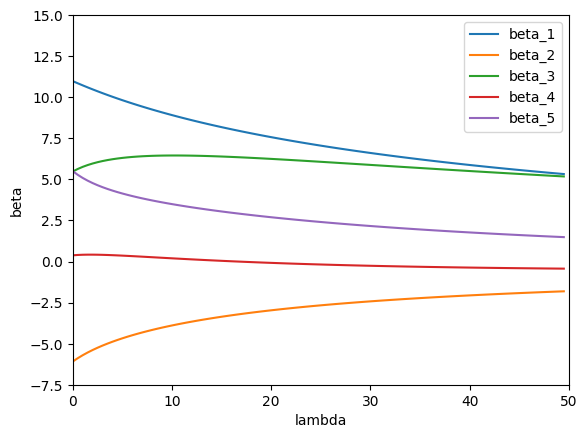

In [13]:
# plot

plt.xlim(0, 50)
plt.ylim(-7.5, 15)
plt.xlabel("lambda")
plt.ylabel("beta")

for j in range(p):
  coef_seq = []
  for l in lambda_seq:
    coef_seq.append(ridge(X, y, l)['beta'][j])
  plt.plot(lambda_seq, coef_seq, label=f"beta_{j+1}")

plt.legend(loc="upper right")
plt.show()

In [25]:
# define inputs
X = df[:, [i for i in range(2,7,1)]]
p = X.shape[1]
y = df[:, 0]
lambda_seq = np.arange(0, 200, 0.5)

In [26]:
def soft_thresholding(rho, lam):
    """
    Soft thresholding operator.
    For a given value rho and threshold lam, it returns:
      sign(rho) * max(|rho| - lam, 0)
    """
    if rho < -lam:
        return rho + lam
    elif rho > lam:
        return rho - lam
    else:
        return 0.0

def lasso_coordinate_descent(X, y, lam, num_iters=1000, tol=1e-6):
    """
    Coordinate descent algorithm for Lasso Regression.

    Parameters:
    -----------
    X : numpy array of shape (n, p) (design matrix)
    y : numpy array of shape (n,) (response vector)
    lam : regularization parameter (lambda)
    num_iters : maximum number of iterations
    tol : tolerance for convergence

    Returns:
    --------
    beta : numpy array of shape (p,)
        Estimated coefficients.
    """
    n, p = X.shape
    beta = np.zeros(p)

    # Precompute feature norms: a_j = (1/n) * sum(x_ij^2)
    feature_norms = np.sum(X**2, axis=0) / n

    for iteration in range(num_iters):
        beta_old = beta.copy()
        for j in range(p):
            # Compute partial residual: r_j = y - X*beta + X[:, j]*beta[j]
            r_j = y - X.dot(beta) + X[:, j] * beta[j]
            # Compute the inner product (scaled by 1/n)
            rho = np.dot(X[:, j], r_j) / n
            # Update beta_j using the soft thresholding rule
            beta[j] = soft_thresholding(rho, lam) / feature_norms[j]

        # Check convergence (using Euclidean norm)
        if np.linalg.norm(beta - beta_old, ord=2) < tol:
            break

    return beta

def lasso(X, y, lam, num_iters=1000, tol=1e-6):
    """
    Wrapper for Lasso regression that returns coefficients in a dictionary.

    Parameters:
    -----------
    X : numpy array of shape (n, p)
    y : numpy array of shape (n,)
    lam : regularization parameter (lambda)
    num_iters : maximum number of iterations (default 1000)
    tol : tolerance for convergence (default 1e-6)

    Returns:
    --------
    result : dict
        Dictionary with key 'beta' containing the coefficient vector.
    """
    beta = lasso_coordinate_descent(X, y, lam, num_iters, tol)
    return {'beta': beta}

In [27]:
lasso(X,y,20)

{'beta': array([11.01618568, -0.11028896, 13.57569691,  3.21508614,  0.        ])}

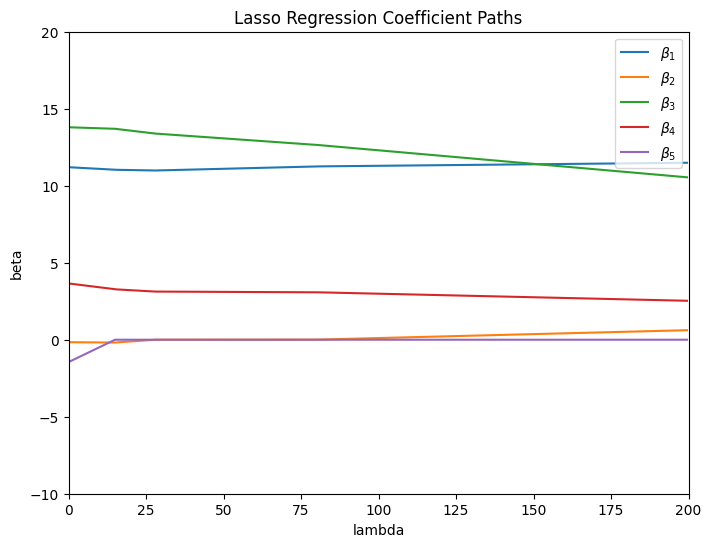

In [28]:
# ------------------------------
# Plot Lasso Coefficient Paths
# ------------------------------

plt.figure(figsize=(8,6))
plt.xlim(0, 200)
plt.ylim(-10, 20)
plt.xlabel("lambda")
plt.ylabel("beta")
plt.title("Lasso Regression Coefficient Paths")

# For each coefficient (there are 5 features), compute the coefficient path over lambda_seq
for j in range(p):
    coef_seq = []
    for lam in lambda_seq:
        coef_seq.append(lasso(X, y, lam)['beta'][j])
    # Convert coef_seq to a numpy array for consistent shape (100,)
    coef_seq = np.array(coef_seq)
    plt.plot(lambda_seq, coef_seq, label=f"$\\beta_{{{j+1}}}$")

plt.legend(loc="upper right")
plt.show()